# **TIME SERIES FORECASTING ___ LSTM**

IMPORTING NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

LOADING AND READING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Electric_Production.csv",index_col='DATE', parse_dates=True)
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [ ]:
df.columns = ["Production"]

In [ ]:
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
df.tail()

,Production
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [ ]:
df.isnull().sum()

Production    0
dtype: int64

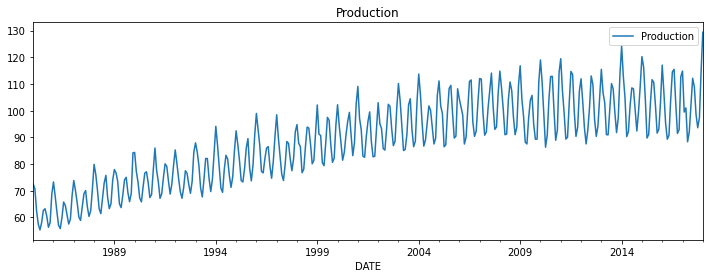

In [ ]:
df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Production')
plt.show(block=False)

TIME SERIES DECOMPOSITION

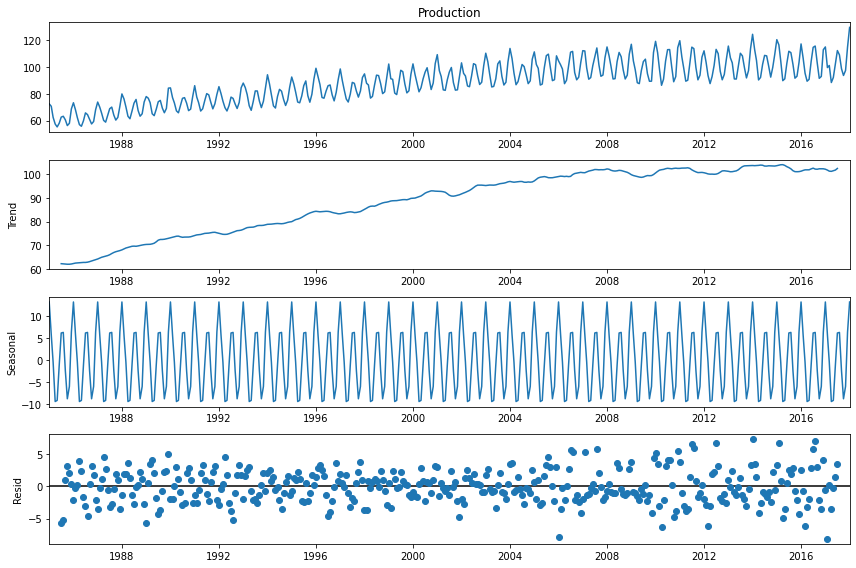

In [ ]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df.Production)
fig = decomposition.plot()
plt.show()

**Looking at the above plot we can see the trend in the Time Series.**

DATA PREPARATION

In [ ]:
train_len = 360
train=df[0:train_len]
test=df[train_len:] 
print("Training set: ", train.shape)
print("Testing set: ", test.shape)

Training set:  (360, 1)
Testing set:  (37, 1)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
n_months = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

APPLYING Model-LSTM

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(n_months, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(generator, epochs=10)

Epoch 1/10
348/348 [==============================] - 5s 7ms/step - loss: 0.0225
Epoch 2/10
348/348 [==============================] - 2s 6ms/step - loss: 0.0136
Epoch 3/10
348/348 [==============================] - 2s 6ms/step - loss: 0.0097
Epoch 4/10
348/348 [==============================] - 2s 6ms/step - loss: 0.0049
Epoch 5/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0028
Epoch 6/10
348/348 [==============================] - 3s 9ms/step - loss: 0.0031
Epoch 7/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 8/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 9/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0024
Epoch 10/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0026


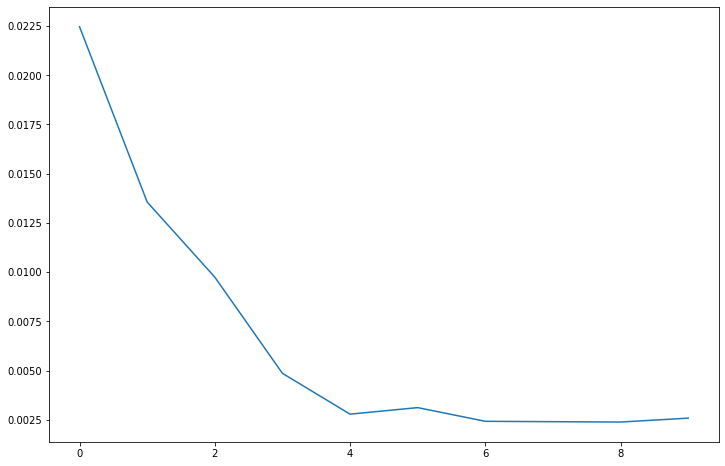

In [ ]:
plt.plot(history.history['loss'])
plt.show()

MODEL EVALUATION

In [ ]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

1/1 [==============================] - 0s 217ms/step


array([[0.8716811]], dtype=float32)

In [ ]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
test['LSTM_Predictions'] = scaler.inverse_transform(test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


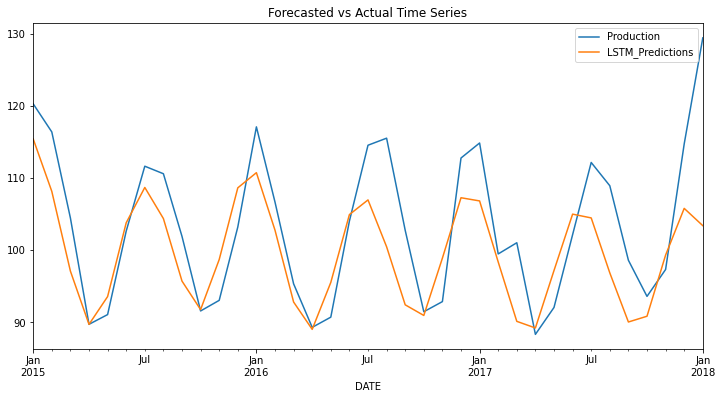

In [ ]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()

In [ ]:
test.head(10)

,Production,LSTM_Predictions
DATE,,
2015-01-01,120.2696,115.408620
2015-02-01,116.3788,108.151354
2015-03-01,104.4706,97.114402
2015-04-01,89.7461,89.736196
2015-05-01,91.0930,93.585976
2015-06-01,102.6495,103.800091
2015-07-01,111.6354,108.694791
2015-08-01,110.5925,104.386871
2015-09-01,101.9204,95.729916




---



---

